In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of n_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def compute_loss(a3, Y):
    
    """
    Implement the loss function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    loss - value of the loss function
    """
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

def load_cat_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/255
    test_set_x = test_set_x_orig/255

    return train_set_x, train_set_y, test_set_x, test_set_y, classes


def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

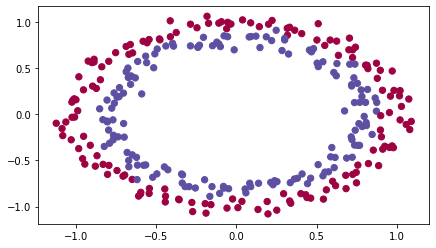

In [4]:
train_X, train_Y, test_X, test_Y = load_dataset()

# Neural Network model

In [32]:
def model(X, Y, learning_rate=0.01, num_iterations=15000, print_cost=True, initialization='he'):
  grads = {}
  costs = []
  m = X.shape[1]
  layers_dims = [X.shape[0], 10, 5, 1]

  if initialization == "zeros":
    parameters = initialize_parameters_zeros(layers_dims)
  elif initialization == "random":
    parameters = initialize_parameters_random(layers_dims)
  elif initialization == "he":
    parameters = initialize_parameters_he(layers_dims)

  for i in range(0, num_iterations):
    a3, cache = forward_propagation(X, parameters)

    cost = compute_loss(a3, Y)

    grads = backward_propagation(X, Y, cache)

    parameters = update_parameters(parameters, grads, learning_rate)

    if print_cost and i%1000 == 0:
      print(f"Cost after iterations {i}: {cost}")
      costs.append(cost)
    
  plt.plot(costs)
  plt.ylabel("cost")
  plt.xlabel("iterations (per hundred)")
  plt.title("Learning rate:"+str(learning_rate))
  plt.show()

  return parameters

# Zero Initialization

In [14]:
def initialize_parameters_zeros(layers_dims):
  L = len(layers_dims)
  parameters = {}

  for l in range(1, L):
    parameters["W"+str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
    parameters["b"+str(l)] = np.zeros((layers_dims[l], 1))
  return parameters

In [15]:
parameters = initialize_parameters_zeros([3,2,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


Cost after iterations 0: 0.6931471805599453
Cost after iterations 1000: 0.6931471805599453
Cost after iterations 2000: 0.6931471805599453
Cost after iterations 3000: 0.6931471805599453
Cost after iterations 4000: 0.6931471805599453
Cost after iterations 5000: 0.6931471805599453
Cost after iterations 6000: 0.6931471805599453
Cost after iterations 7000: 0.6931471805599453
Cost after iterations 8000: 0.6931471805599453
Cost after iterations 9000: 0.6931471805599453
Cost after iterations 10000: 0.6931471805599455
Cost after iterations 11000: 0.6931471805599453
Cost after iterations 12000: 0.6931471805599453
Cost after iterations 13000: 0.6931471805599453
Cost after iterations 14000: 0.6931471805599453


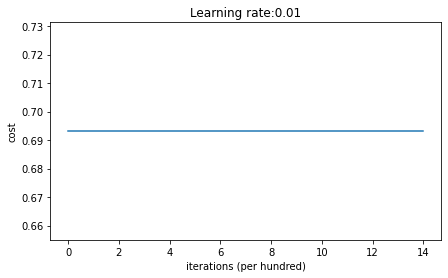

On the train set:
Accuracy: 0.5
On the test set:
Accuracy: 0.5


In [16]:
parameters = model(train_X, train_Y, initialization = "zeros")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [17]:
print ("predictions_train = " + str(predictions_train))
print ("predictions_test = " + str(predictions_test))

predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


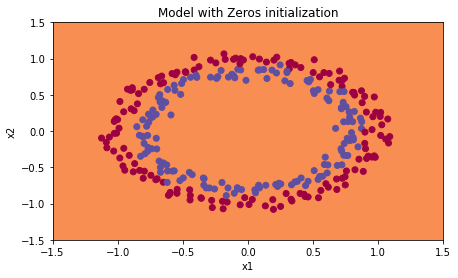

In [18]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# Random Initialization

In [24]:
def initialize_parameters_random(layers_dims):
  np.random.seed(3)
  parameters = {}
  L = len(layers_dims)

  for l in range(1, L):
    parameters["W"+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10
    parameters["b"+str(l)] = np.zeros((layers_dims[l], 1))
  return parameters

In [25]:
parameters = initialize_parameters_random([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in multiply


Cost after iterations 0: inf
Cost after iterations 1000: 0.6247924745506072
Cost after iterations 2000: 0.5980258056061102
Cost after iterations 3000: 0.5637539062842213
Cost after iterations 4000: 0.5501256393526495
Cost after iterations 5000: 0.5443826306793814
Cost after iterations 6000: 0.5373895855049121
Cost after iterations 7000: 0.47157999220550006
Cost after iterations 8000: 0.39770475516243037
Cost after iterations 9000: 0.3934560146692851
Cost after iterations 10000: 0.3920227137490125
Cost after iterations 11000: 0.38913700035966736
Cost after iterations 12000: 0.3861358766546214
Cost after iterations 13000: 0.38497629552893475
Cost after iterations 14000: 0.38276694641706693


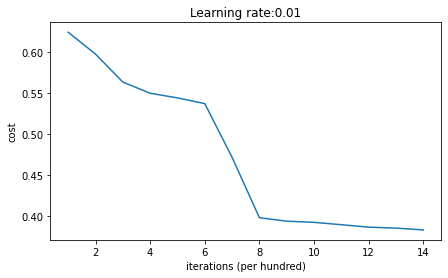

On the train set:
Accuracy: 0.83
On the test set:
Accuracy: 0.86


In [26]:
parameters = model(train_X, train_Y, initialization = "random")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [27]:
print (predictions_train)
print (predictions_test)

[[1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1
  1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
  0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
  1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0
  0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
  1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1
  0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1
  1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1
  1 1 1 1 0 0 0 1 1 1 1 0]]
[[1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1
  0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0
  1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0]]


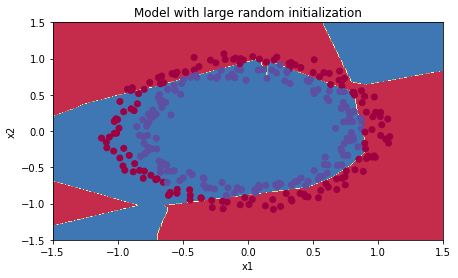

In [28]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# He Initialization

In [29]:
def initialize_parameters_he(layers_dims):
  np.random.seed(3)
  L = len(layers_dims)
  parameters = {}

  for l in range(1, L):
    parameters["W"+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2./ layers_dims[l-1])
    parameters["b"+str(l)] = np.zeros((layers_dims[l], 1))
  
  return parameters

In [30]:
parameters = initialize_parameters_he([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
b2 = [[0.]]


Cost after iterations 0: 0.8830537463419761
Cost after iterations 1000: 0.6879825919728063
Cost after iterations 2000: 0.6751286264523371
Cost after iterations 3000: 0.6526117768893805
Cost after iterations 4000: 0.6082958970572938
Cost after iterations 5000: 0.5304944491717495
Cost after iterations 6000: 0.4138645817071794
Cost after iterations 7000: 0.3117803464844441
Cost after iterations 8000: 0.23696215330322562
Cost after iterations 9000: 0.1859728720920684
Cost after iterations 10000: 0.15015556280371808
Cost after iterations 11000: 0.12325079292273551
Cost after iterations 12000: 0.09917746546525937
Cost after iterations 13000: 0.08457055954024283
Cost after iterations 14000: 0.07357895962677366


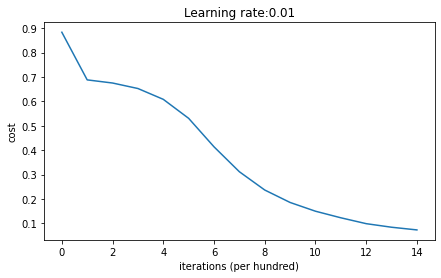

On the train set:
Accuracy: 0.9933333333333333
On the test set:
Accuracy: 0.96


In [33]:
parameters = model(train_X, train_Y, initialization = "he")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

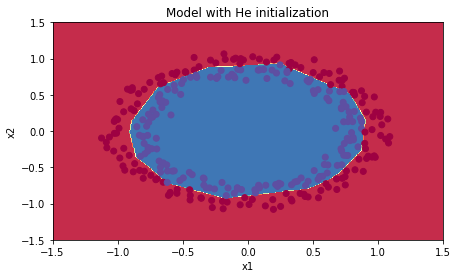

In [34]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)